In [35]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()


In [36]:
# Parameters
years_in = [1900, 2022]

In [37]:
def read_data(fname, start_year, end_year):
    df = pd.read_csv(fname).set_index('country')
    df = df.replace({'[bB]': '*1e9', '[kK]': '*1e3', '[Mm]': '*1e6'}, regex=True)
    df = df.T.loc[str(start_year):str(end_year)].apply(lambda x: x.map(pd.eval).astype(int))
    return df

In [46]:
# Another approximation
interesting_values = ['population', 'electricity_generation', 'renewables_electricity', 'fossil_electricity']

# Load file
df_energy = pd.read_csv('./data/energy_data.csv')
# Get interesting columns
df_energy = df_energy[['country', 'iso_code', 'year'] + interesting_values]
# Remove rows with continents, unexisting countries.
df_energy = df_energy[pd.notna(df_energy['iso_code'])]
# Create separated tables pivotting
separated_df = {value: df_energy.pivot(columns='country', index='year', values=value) for value in interesting_values} 
df_energy[df_energy['country'] == 'World']

,country,iso_code,year,population,electricity_generation,renewables_electricity,fossil_electricity
16904,World,OWID_WRL,1900,1.650000e+09,NaN,NaN,NaN
16905,World,OWID_WRL,1901,1.659948e+09,NaN,NaN,NaN
16906,World,OWID_WRL,1902,1.669997e+09,NaN,NaN,NaN
16907,World,OWID_WRL,1903,1.680115e+09,NaN,NaN,NaN
16908,World,OWID_WRL,1904,1.690269e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...
17020,World,OWID_WRL,2016,7.464022e+09,23925.445,5900.412,15496.799
17021,World,OWID_WRL,2017,7.547859e+09,24570.376,6276.014,15750.371
17022,World,OWID_WRL,2018,7.631091e+09,25559.572,6712.063,16233.117
17023,World,OWID_WRL,2019,7.713468e+09,25899.806,7065.089,16114.042


In [56]:
ren_ener = df_energy[(df_energy['country'] != 'World') & (df_energy['year'] >= 1990) & (df_energy['year'] < 2020)]
ren_ener['renew_per_capita'] = ren_ener['renewables_electricity'] / ren_ener['electricity_generation']
ren_ener['fos_per'] = ren_ener['fossil_electricity'] / ren_ener['electricity_generation']

fig = px.choropleth(ren_ener, locations="iso_code",
                    color="renew_per_capita", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma, 
                    animation_frame="year",)
fig.show()

In [33]:
df_energy

,country,iso_code,year,population,electricity_generation,renewables_electricity,fossil_electricity
0,Afghanistan,AFG,1900,5021241.0,NaN,NaN,NaN
1,Afghanistan,AFG,1901,5053439.0,NaN,NaN,NaN
2,Afghanistan,AFG,1902,5085403.0,NaN,NaN,NaN
3,Afghanistan,AFG,1903,5118005.0,NaN,NaN,NaN
4,Afghanistan,AFG,1904,5150814.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
17427,Zimbabwe,ZWE,2015,13815000.0,9.388,5.076,4.312
17428,Zimbabwe,ZWE,2016,14030000.0,6.826,3.111,3.715
17429,Zimbabwe,ZWE,2017,14237000.0,7.310,4.091,3.219
17430,Zimbabwe,ZWE,2018,14439000.0,9.133,5.201,3.932


<AxesSubplot:>

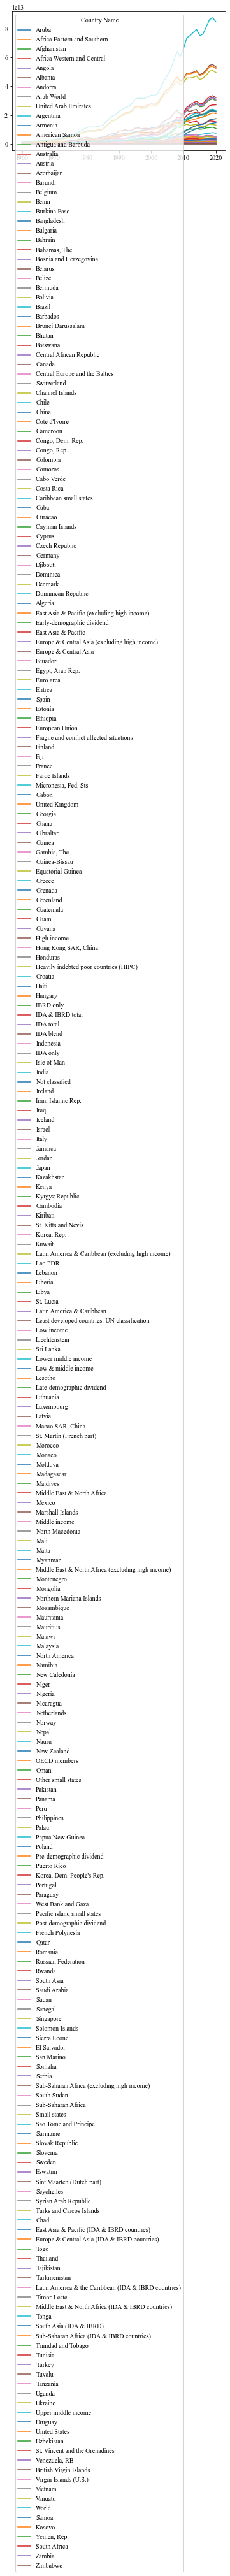

In [59]:
# GDP from other file
df_gdp = pd.read_csv('./data/gdp.csv', header=2)
df_gdp = df_gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 66']).set_index('Country Name').T
df_gdp.index = df_gdp.index.astype(int)
df_gdp.plot()


In [7]:
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    
    Thanks to: https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    z[:, :, -1] = np.linspace(0, alpha, 100)[:, None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im


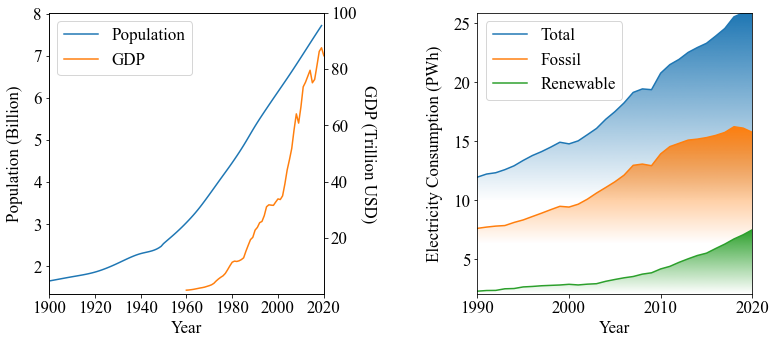

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import matplotlib
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['font.family'] = 'times new roman'

def clean_elect(series):
    elect = series.World
    elect = elect[pd.notna(elect)]
    x = elect.index
    y = elect.values/1e3
    return x, y

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

ax = axes[1]

gradient_fill(*clean_elect(separated_df['electricity_generation']), fill_color='tab:blue', ax=ax, label='Total')
gradient_fill(*clean_elect(separated_df['fossil_electricity']), fill_color='tab:orange', ax=ax, label='Fossil')
gradient_fill(*clean_elect(separated_df['renewables_electricity']), fill_color='tab:green', ax=ax, label='Renewable')

ax.set_ylabel('Electricity Consumption (PWh)', labelpad=10)
ax.set_xlabel('Year')
ax.set_xlim((1990, 2020))
ax.legend()

ax_pop = axes[0]
ax_gdp = ax_pop.twinx()
(separated_df['population'].World/1e9).plot(ax=ax_pop, color='tab:blue', label='Population')
(df_gdp.World/1e12).plot(ax=ax_gdp, color='tab:orange', label='GDP')

ax_pop.plot([], [], color='tab:orange', label='GDP')

ax_pop.set_xlabel('Year')
ax_gdp.set_ylabel('GDP (Trillion USD)', rotation=270, labelpad=20)
ax_pop.set_ylabel('Population (Billion)', labelpad=10)
ax_gdp.set_ylim((0.1, 100))
ax_gdp.set_xlim((1900, 2020))

ax_pop.set_xticks(range(1900, 2021, 20))
ax_pop.legend()
plt.tight_layout(pad=3)
fig.savefig('figures/population_gdp.pdf', dpi=300)